# Finding Kermit
Training: Episode 02-01-01  
Test: Episode 02-04-04  
Validation: Episode 03-04-03  

## Video

The best classifier approach from visual was histogram+blobs with the highest precision+F1 on val-set, so this classifier is used here now.

In [1]:
# Load Data
import pandas as pd
import numpy as np

x_train = pd.read_csv("../data/ep1_visual_full.csv", delimiter=",", na_values="").fillna(0)
y_train = x_train["kermit_video"]
x_train = x_train.filter(regex=("_hist|_blob"))

x_test = pd.read_csv("../data/ep2_visual_full.csv", delimiter=",", na_values="").fillna(0)
y_test = x_test["kermit_video"]
x_test = x_test.filter(regex=("_hist|_blob"))

x_val = pd.read_csv("../data/ep3_visual_full.csv", delimiter=",", na_values="").fillna(0)
y_val = x_val["kermit_video"]
x_val = x_val.filter(regex=("_hist|_blob"))

# bring to same shape
cols = list(x_val.iloc[:,(x_train.shape[1]-x_val.shape[1]):].columns)
for col in cols:
    x_train[col] = 0

cols = list(x_val.iloc[:,(x_test.shape[1]-x_val.shape[1]):].columns)
for col in cols:
    x_test[col] = 0

if x_val.shape[1] == x_test.shape[1] == x_train.shape[1]:
    print("all set!")

/Users/ostritze/opt/anaconda3/envs/simmod/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (787) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


all set!


Accuracy:   0.7631
Precision:  0.9209
Recall:     0.3056
F1:         0.4589


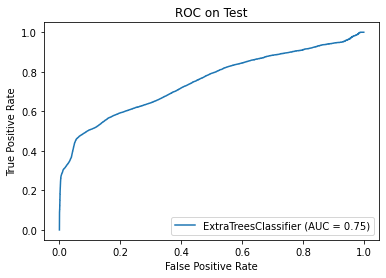

In [2]:
# GET PREDICTIONS
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve

# Best performing pipeline from tpot
pipe = ExtraTreesClassifier(bootstrap=True, criterion="gini", max_features=0.25, min_samples_leaf=8, min_samples_split=11, n_estimators=100)
if hasattr(pipe, 'random_state'):
    setattr(pipe, 'random_state', 42)
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)

print("Accuracy:  ", round(accuracy_score(y_test,y_pred),4) )
print("Precision: ", round(precision_score(y_test,y_pred),4) )
print("Recall:    ", round(recall_score(y_test,y_pred),4) )
print("F1:        ", round(f1_score(y_test,y_pred),4) )

plot_roc_curve(pipe, x_test, y_test)
plt.title("ROC on Test")
plt.show()

Accuracy:   0.567
Precision:  0.8145
Recall:     0.0907
F1:         0.1632


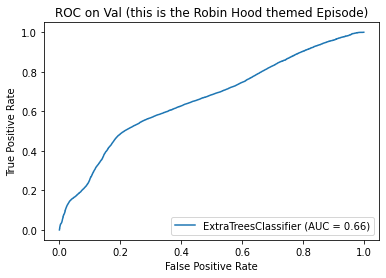

In [3]:
y_pred = pipe.predict(x_val)
print("Accuracy:  ", round(accuracy_score(y_val,y_pred),4) )
print("Precision: ", round(precision_score(y_val,y_pred),4) )
print("Recall:    ", round(recall_score(y_val,y_pred),4) )
print("F1:        ", round(f1_score(y_val,y_pred),4) )

video_predictions = y_pred.copy() #save for later

plot_roc_curve(pipe, x_val, y_val)
plt.title("ROC on Val (this is the Robin Hood themed Episode)")
plt.show()

## Audio

In [4]:
# DATA
train_data = pd.read_csv('../data/ep1_flat_mfcc.csv', sep=',', dtype=np.float64)
train_target = pd.read_csv('../data/gt/gt_02_01_01.csv', sep=',').head(len(train_data)).kermit_audio
test_data = pd.read_csv('../data/ep2_flat_mfcc.csv', sep=',', dtype=np.float64)
test_target = pd.read_csv('../data/gt/gt_02_04_04.csv.csv', na_values=[None, ' ', '']).fillna(0).head(len(test_data)).kermit_audio

In [5]:
# MODEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# Pipeline as exported from TPOT
pipeline = make_pipeline(
    StackingEstimator(estimator=BernoulliNB(alpha=0.001, fit_prior=False)),
    RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(pipeline.steps, 'random_state', 42)

pipeline.fit(train_data, train_target)

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=BernoulliNB(alpha=0.001,
                                                         fit_prior=False))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=0.2, min_samples_leaf=8,
                                        min_samples_split=4,
                                        random_state=42))])

Precision Train:  1.0
Precision Test:   0.8235


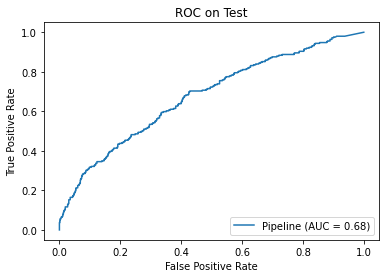

In [6]:
# EVALUATE AUDIO PREDICTIONS ALONE
from sklearn.metrics import precision_score

# predict training data
print("Precision Train: ", precision_score(train_target, pipeline.predict(train_data)))

# predict test data
print("Precision Test:  ", round( precision_score(test_target, pipeline.predict(test_data)),4 ))
plot_roc_curve(pipeline, test_data, test_target)
plt.title("ROC on Test")
plt.show()

Precision Val:   0.6667


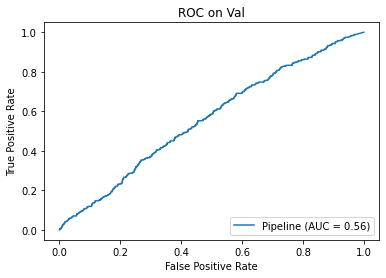

In [7]:
# Load truth for episode 3
val_target = pd.read_csv('../data/gt/gt_03_04_03.csv', sep=',')

# Video predictions
#video_predictions = np.round(np.random.random((len(train_target),))) ### PLACEHOLDER
### from visual part above


# Audio predictions
val_audio = pd.read_csv('../data/ep3_flat_mfcc.csv', sep=',', dtype=np.float64)
audio_predictions = pipeline.predict(val_audio)

min_len = min([len(val_target), len(audio_predictions)])
val_target = val_target.head(min_len)

print("Precision Val:  ", round( precision_score(val_target["kermit_audio"], pipeline.predict(val_audio)),4 ))
plot_roc_curve(pipeline, val_audio, val_target["kermit_audio"])
plt.title("ROC on Val")
plt.show()

# Combined

In [8]:
# Load truth for episode 3
val_target = pd.read_csv('../data/gt/gt_03_04_03.csv', sep=',')

# Video predictions
#video_predictions = np.round(np.random.random((len(train_target),))) ### PLACEHOLDER
### from visual part above


# Audio predictions
val_audio = pd.read_csv('../data/ep3_flat_mfcc.csv', sep=',', dtype=np.float64)
audio_predictions = pipeline.predict(val_audio)

# Video predictions
video_predictions = pipe.predict(x_val)

In [9]:
# adjust lengths since mfcc apparently drops late seconds without audio
min_len = min([len(val_target), len(video_predictions), len(audio_predictions)])
val_target = val_target.head(min_len)
audio_predictions = audio_predictions[:min_len]

# video predictions are per frame, audio per second. Expand audio...
val_per_frame = pd.read_csv("../data/ep3_visual_full.csv", delimiter=",", na_values="").fillna(0) # load per frame truth from visual features
val_per_frame["video_pred"] = video_predictions # add video predictions to it
val_target["audio_pred"] = audio_predictions # add audio_pred to audio features, because we have minute+second there
df = pd.merge(val_per_frame, val_target, left_on=['minute','second'], right_on = ['Min','Sec'], suffixes=("","_y")).drop(["Min","Sec"], axis=1) # merge both on min+sec
results = df[["kermit_video", "kermit_audio", "audio_pred", "video_pred"]].copy()

In [10]:
results

,kermit_video,kermit_audio,audio_pred,video_pred
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
38445,0,0,0,0
38446,0,0,0,0
38447,0,0,0,0
38448,0,0,0,0


In [11]:
# combine truths
or_truth = [results.kermit_video[i] or results.kermit_audio[i] for i in range(results.shape[0])]
and_truth = [results.kermit_video[i] and results.kermit_audio[i] for i in range(results.shape[0])]

# combine predictions
or_predictions = [results.video_pred[i] or results.audio_pred[i] for i in range(results.shape[0])]
and_predictions = [results.video_pred[i] and results.audio_pred[i] for i in range(results.shape[0])]

#print(len(or_predictions), len(and_predictions))
print(np.array(or_truth).sum(), np.array(and_truth).sum())
print(np.array(or_predictions).sum(), np.array(and_predictions).sum())

18300 8450
2048 22


Accuracy:   0.5581
Precision:  0.8193
Recall:     0.0917
F1:         0.1649


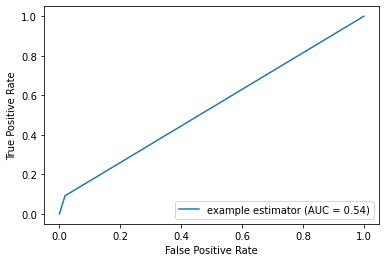

In [12]:
# OR truth
from sklearn import metrics

print("Accuracy:  ", round(accuracy_score(or_truth,or_predictions),4) )
print("Precision: ", round(precision_score(or_truth,or_predictions),4) )
print("Recall:    ", round(recall_score(or_truth,or_predictions),4) )
print("F1:        ", round(f1_score(or_truth,or_predictions),4) )

fpr, tpr, thresholds = metrics.roc_curve(or_truth, or_predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()  
plt.show()      

Accuracy:   0.7808
Precision:  1.0
Recall:     0.0026
F1:         0.0052


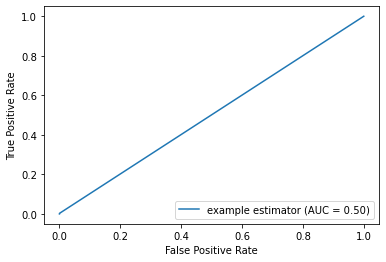

In [13]:
# AND truth
print("Accuracy:  ", round(accuracy_score(and_truth,and_predictions),4) )
print("Precision: ", round(precision_score(and_truth,and_predictions),4) )
print("Recall:    ", round(recall_score(and_truth,and_predictions),4) )
print("F1:        ", round(f1_score(and_truth,and_predictions),4) )

fpr, tpr, thresholds = metrics.roc_curve(and_truth, and_predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()  
plt.show()  